In [1]:
from robust_hw import columns, extract_rotations, interpolate, integrate, read_hdf, read_csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from scipy.ndimage import uniform_filter, gaussian_filter

In [ ]:
period = 10
log_path = 'data/Z-230901A.csv'

theta_raw = np.unwrap(read_csv(log_path, columns['theta']))

freq_raw = -1.0 * read_csv(log_path, 'Sensor1 [Fundamental freq]')
theta_ext, freq_ext = extract_rotations(theta_raw, freq_raw)
freq_sgn = integrate(freq_ext, np.zeros(freq_ext.size), period)
freq_bgd = interpolate(freq_ext, period, period - 2)
freq_int = integrate(freq_ext, freq_bgd, period)

In [4]:
s1_factor = read_csv(log_path, columns['s1_factor'])
s1_background = read_csv(log_path, columns['s1_bgd'])
s1_signal = read_csv(log_path, columns['s1_sgn'])
# s1_cleaned_signal = read_csv(log_path, 'Mag3 [QCM,S1 cleaned signal] (um/rot)')
factor = 1e-3

theta_ext, signal = extract_rotations(theta_raw, s1_signal)
theta_ext, background = extract_rotations(theta_raw, s1_background)

# _, log_signal = extract_rotations(theta_raw, read_csv(log_path, 'Mag3 [Holt Winters feedback,S1 Smooth signal] (layers)'))

In [40]:
s1_factor = read_csv(log_path, columns['s2_factor'])
s1_background = read_csv(log_path, columns['s2_bgd'])
s1_signal = read_csv(log_path, columns['s2_sgn'])
s1_cleaned_signal = read_csv(log_path, 'Mag3 [QCM,S2 cleaned signal] (um/rot)')
factor = 1e-3

theta_ext, signal = extract_rotations(theta_raw, s1_signal)
theta_ext, background = extract_rotations(theta_raw, s1_background)

_, log_signal = extract_rotations(theta_raw, read_csv(log_path, 'Mag3 [Holt Winters feedback,S2 Smooth signal] (layers)'))

NameError: name 's1_cleaned_signal' is not defined

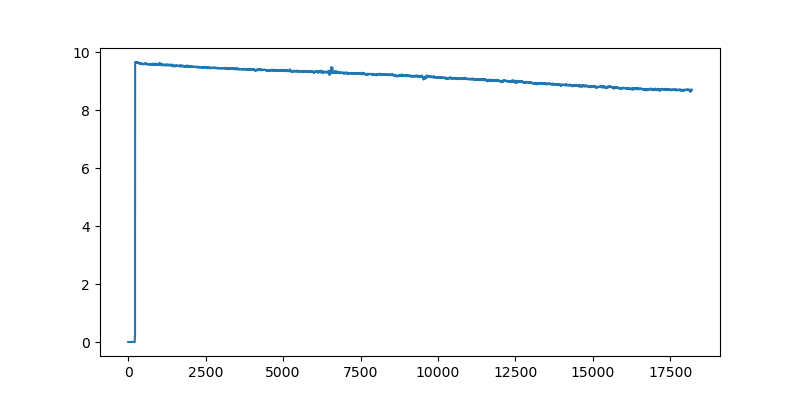

In [14]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(theta_raw, freq_raw)
# ax.plot(theta_ext, freq_ext)
ax.plot(theta_raw / (2 * np.pi), factor * (s1_signal - s1_background), label="S1_signal - S1_background at each cycle (10 layers)")
# ax.plot(theta_ext[::period], factor * (signal - background)[::period], label="S1_signal - S1_background at each cycle (10 layers)")
ax.plot(theta_raw / (2 * np.pi), s1_cleaned_signal, linestyle='dashed', label="S1_cleaned_signal from output.csv")
# ax.plot(theta_ext[::period], series, label="S1 smoothing input from debug.log")
# ax.plot(theta_ext[::period][5:], input[:26, 1])

ax.legend(fontsize=15)
ax.grid(True)
# ax.set_ylim(0.85, 1.05)
plt.show()

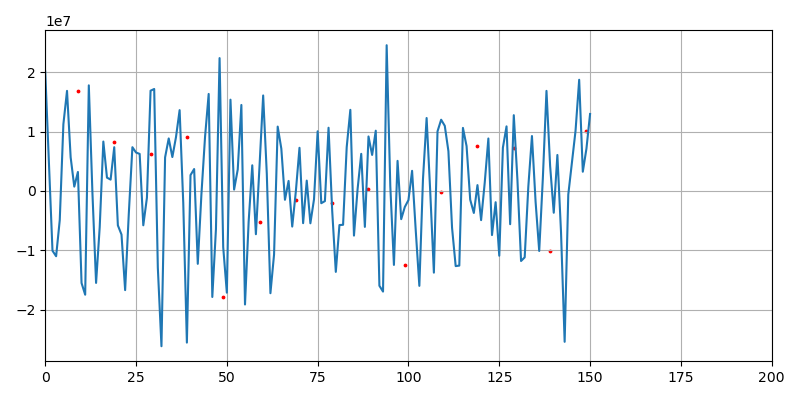

In [14]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(theta_ext, np.gradient(freq_ext))
ax.scatter(theta_ext[period - 1::period], np.gradient(freq_ext)[period - 4::period], s=3, c='r')
ax.grid(True)

ax.set_xlim(0, 200)
fig.tight_layout()
plt.show()

# Robust smoothing

In [2]:
from robust_hw import create_smoother, initialise, smoothing_step
import jax.numpy as jnp
from tqdm.auto import tqdm

In [11]:
# series of signal - background
theta = theta_ext[::period]
# series = freq_int[::period]
series = factor * (signal - background)[::period]

# series /= series.max()

# results of a training
smoothe_over_signal, smoothe_over_gradient, smoothe_over_variance = 1, 1, 1

#creating a smoother object
smoother = create_smoother(smoothe_over_signal, smoothe_over_gradient, smoothe_over_variance)

# skipping first n_start points and allocating n_warmup points to create an initial state
n_start, n_warmup = 1, 10

warmup, samples = (jnp.array(series[n_start:n_start + n_warmup]),
                   jnp.array(series[n_start + n_warmup:]))

step = smoothing_step(smoother)

# creating an initial state
state = initialise(smoother, warmup)

# performing real-time smoothing
# result = []
# states = []
# for elem in tqdm(samples):
#     smoothed, state = step(elem, state)
#     result.append(smoothed)
#     states.append(state)

In [13]:
warmup

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

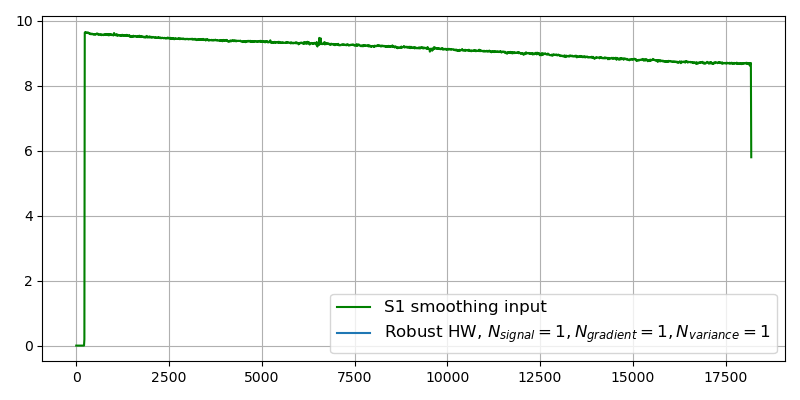

In [8]:
import matplotlib.pyplot as plt

%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(theta_raw / (2 * np.pi), old_s1_ftr, c='b', alpha=0.7, linestyle='dashed', label="s1 factor")
# ax.plot(theta_ext[::period], log_signal[::period], c='r', alpha=0.7, linestyle='dashed', label="Martin's Robust HW")
# ax.plot(theta[n_start + n_warmup:], [state.moment for state in states])
# ax.scatter(theta, series, s=1, alpha=0.1, c='k', label=r'$s1_{signal} - s1_{bgd}$')
ax.plot(theta, series, c='g', label="S1 smoothing input")
ax.plot(theta[n_start + n_warmup:], result, alpha=1.0,
        label=fr'Robust HW, $N_{{signal}} = {smoothe_over_signal}, '\
              fr'N_{{gradient}} = {smoothe_over_gradient}, '\
              fr'N_{{variance}} = {smoothe_over_variance}$')
# ax.plot(theta_ext[::period], log_signal[::period], c='r', alpha=0.7, linestyle='dashed', label="Martin's Robust HW")

ax.legend(fontsize=12)
# ax.set_ylim(0.86, 1.0)
ax.grid(True)
fig.tight_layout()
plt.show()

In [2]:
from robust_hw import inject_hyperparams, meta_step, robust_holt_winters
import optax as ox
import jax
import jax.numpy as jnp
import tqdm

log_path = 'data/Z-230901A.csv'
init_value, n_iter, learning_rate, period, seed = 10.0, 2000, 3e-3, 10, 0
sizes = (200, 400, 200)

theta_raw = jnp.unwrap(read_csv(log_path, columns['theta']))
signal = read_csv(log_path, columns["s1_sgn"])
background = read_csv(log_path, columns["s1_bgd"])

print("Preparing data...")

_, signal = extract_rotations(theta_raw, signal)
_, background = extract_rotations(theta_raw, background)

series = (signal - background)[::period]


Preparing data...


In [3]:
smoother = inject_hyperparams(robust_holt_winters)(lambda1=init_value**-1,
                                                   lambda2=init_value**-1,
                                                   lambda_sigma=init_value**-1)
schedule = ox.cosine_onecycle_schedule(n_iter, learning_rate)
opt = ox.inject_hyperparams(ox.adam)(learning_rate=schedule)

decay = jnp.full(3, -jnp.log(init_value - 1))
opt_state = opt.init(decay)

sizes = (200, 400, 200)
n_warmup, n_train, n_test = sizes
step = meta_step(smoother, opt)
key = jax.random.PRNGKey(seed)
criteria, decays = [], []

with tqdm.trange(n_iter, desc="Training") as pbar:
    for i in pbar:
        if i % 100 == 0:
            new_values = jax.nn.sigmoid(decay)**-1
            pbar.write(f"sum_over_signal = {new_values[0]:<7.3f}, " +
                       f"sum_over_gradient = {new_values[1]:<7.3f}, " +
                       f"sum_over_variance = {new_values[2]:<7.3f}")
        idx = jax.random.randint(key, (1,), n_warmup, series.size - n_train - n_test)[0]

        state = smoother.init(series[idx - n_warmup:idx])
        train, test = series[idx:idx + n_train], series[idx + n_train:idx + n_train + n_test]

        crit, decay, state, opt_state = step(decay, train, test, state, opt_state)
        pbar.set_postfix_str(f"loss = {crit:.2e}")

        criteria.append(crit)
        decays.append(decay)

Training:   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

sum_over_signal = 10.000 , sum_over_gradient = 10.000 , sum_over_variance = 10.000 


Training:   6%|███                                                    | 110/2000 [00:03<00:26, 71.23it/s, loss = 4.55e+03]

sum_over_signal = 10.172 , sum_over_gradient = 10.168 , sum_over_variance = 9.836  


Training:  11%|█████▊                                                 | 211/2000 [00:05<00:20, 88.36it/s, loss = 4.26e+03]

sum_over_signal = 10.764 , sum_over_gradient = 10.688 , sum_over_variance = 9.353  


Training:  16%|████████▌                                              | 313/2000 [00:06<00:18, 89.00it/s, loss = 3.65e+03]

sum_over_signal = 12.414 , sum_over_gradient = 11.735 , sum_over_variance = 8.293  


Training:  21%|███████████▍                                           | 414/2000 [00:07<00:17, 88.95it/s, loss = 3.32e+03]

sum_over_signal = 14.751 , sum_over_gradient = 12.238 , sum_over_variance = 7.100  


Training:  26%|██████████████▏                                        | 514/2000 [00:08<00:16, 88.22it/s, loss = 3.20e+03]

sum_over_signal = 16.439 , sum_over_gradient = 11.774 , sum_over_variance = 6.006  


Training:  31%|████████████████▉                                      | 615/2000 [00:09<00:15, 88.21it/s, loss = 3.17e+03]

sum_over_signal = 16.974 , sum_over_gradient = 11.521 , sum_over_variance = 5.214  


Training:  36%|███████████████████▋                                   | 716/2000 [00:10<00:14, 87.36it/s, loss = 3.15e+03]

sum_over_signal = 16.831 , sum_over_gradient = 11.588 , sum_over_variance = 4.629  


Training:  41%|██████████████████████▍                                | 818/2000 [00:11<00:13, 89.22it/s, loss = 3.13e+03]

sum_over_signal = 16.544 , sum_over_gradient = 11.732 , sum_over_variance = 4.126  


Training:  45%|████████████████████████▌                              | 894/2000 [00:12<00:15, 70.28it/s, loss = 3.11e+03]


KeyboardInterrupt: 

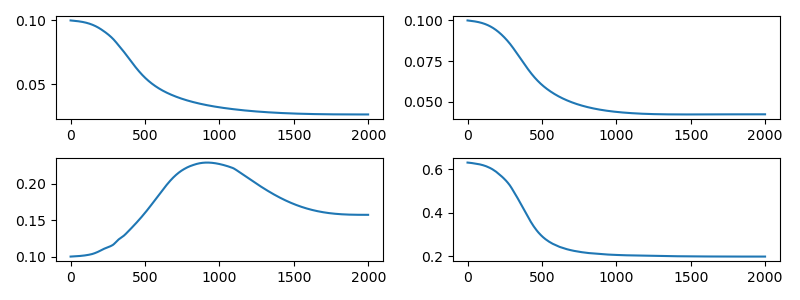

In [12]:
%matplotlib widget
fig, ax = plt.subplots(2, 2, figsize=(8, 3))
ax[0][0].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 0]))
ax[0][1].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 1]))
ax[1][0].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 2]))
ax[1][1].plot(criteria)
fig.tight_layout()
plt.show()